# Content-based similarities
This notebook shows the process used to calculate similarities among the informative videos maintained by the +TV4E platform. In addition, a 2D-graph shows how these items are arranged in the vector space. Thi script must be run in an offline mode to calculate the similarities. 

Library requirements:
* Pandas
* NumPy
* Scikit-learn 
* NLTK (w/ portuguese stop words)
* Seaborn 
* Matplotlib

In [1]:
# for Python 2: use print only as a function
from __future__ import print_function

### Part 1 - Examine the data

In [2]:
# read CSV using a relative path
import pandas as pd
path = 'videos.csv'
df_videos = pd.read_csv(path)

In [3]:
# examine the shape of the dataframe
df_videos.shape

(415, 5)

In [4]:
# examine the first rows
df_videos.head()

,id,title,desc,asgie_title_pt,text_contents
0,788,"Ministra admite ""constrangimentos"" no alojamen...",A ministra da Administração Interna admitiu qu...,Segurança,"Ministra admite ""constrangimentos"" no alojamen..."
1,789,Um quarto dos homens com VIH que fazem sexo co...,Há um “relaxamento” nos comportamentos prevent...,Saúde e Bem-Estar,Um quarto dos homens com VIH que fazem sexo co...
2,791,SNS vai pagar transporte de doentes que precis...,"Até agora, os doentes que precisassem de se de...",Saúde e Bem-Estar,SNS vai pagar transporte de doentes que precis...
3,793,FESTIVAL DOS CANAIS 2017 | APRESENTAÇÃO PÚBLICA,A Sessão Pública de apresentação da edição do ...,Serviços Autárquicos,FESTIVAL DOS CANAIS 2017 | APRESENTAÇÃO PÚBLIC...
4,794,Câmara de Aveiro confirma acordo para Oliveire...,"A Câmara de Aveiro confirma que ""formalizou um...",Serviços Autárquicos,Câmara de Aveiro confirma acordo para Oliveire...


In [5]:
# examine the class distribution and check percentages of ASGIE types
asgies = df_videos.asgie_title_pt.value_counts().to_frame()
asgies['percents'] = ""
asgies['percents'] = (asgies.asgie_title_pt/df_videos.shape[0])*100
asgies

,asgie_title_pt,percents
Saúde e Bem-Estar,171,41.204819
Serviços Autárquicos,157,37.831325
Cultura,49,11.807229
Segurança,27,6.506024
Finanças,11,2.650602


In [6]:
# show all lines in ASGIE 'Finanças'
df_videos_financas = df_videos[(df_videos.asgie_title_pt=='Finanças')]
df_videos_financas

,id,title,desc,asgie_title_pt,text_contents
15,855,"Movimento ""Frente Cívica"" reclama descida do I...","Sendo a energia eléctrica um bem essencial, e ...",Finanças,"Movimento ""Frente Cívica"" reclama descida do I..."
68,973,Buffett: “Ser-me-á dado um corte de imposto de...,Warren Buffett considera que a reforma da saúd...,Finanças,Buffett: “Ser-me-á dado um corte de imposto de...
91,1010,Factura da Sorte: todos apostam mas poucos son...,O concurso do Fisco que premeia quem pede fact...,Finanças,Factura da Sorte: todos apostam mas poucos son...
108,1032,"FMI: Portugal atingirá défice de 1,5% do PIB ""...","Notando que em 2016 Portugal teve um ""desempen...",Finanças,"FMI: Portugal atingirá défice de 1,5% do PIB ""..."
135,1060,Fisco “recusa-se” a cobrar multas de 12 milhõe...,"“A fraude é massiva nos comboios urbanos”, adm...",Finanças,Fisco “recusa-se” a cobrar multas de 12 milhõe...
149,1075,Software do fisco só teve “apagão” no caso das...,O programa que serve para registar as transfer...,Finanças,Software do fisco só teve “apagão” no caso das...
192,1133,"Fisco deixa prescrever 306,3 milhões em impost...",As dívidas fiscais prescritas em 2016 mais do ...,Finanças,"Fisco deixa prescrever 306,3 milhões em impost..."
207,1159,Marcelo promulga sistema electrónico de devolu...,O decreto-lei simplifica os procedimentos de r...,Finanças,Marcelo promulga sistema electrónico de devolu...
254,1221,Anadia: Ecoparque sucessivamente vandalizado,NaN,Finanças,Anadia: Ecoparque sucessivamente vandalizado
326,1332,Separados com novas regras para dividir os fil...,"Ter sido casado, unido de facto ou nunca ter v...",Finanças,Separados com novas regras para dividir os fil...


### Part 2 - Vectorize text contents

In [7]:
# import and retrieve portuguese stop words
# stop words are not considered as token as usually they carry no meaning (!)
from nltk.corpus import stopwords
portuguese_stop_words = stopwords.words('portuguese')
portuguese_stop_words

['de',
 'a',
 'o',
 'que',
 'e',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera',
 'es

In [8]:
# import and instantiate TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=2, max_df=0.5, stop_words=portuguese_stop_words)

In [9]:
# fit (train) the vectorizer with the corpus from video text contents
tfidf_matrix = tfidf.fit_transform(df_videos['text_contents'])
tfidf_matrix

<415x13672 sparse matrix of type '<class 'numpy.float64'>'
	with 68301 stored elements in Compressed Sparse Row format>

In [10]:
# show the size of the vocabulary
len(tfidf.vocabulary_)

13672

In [11]:
# show the vocabulary
tfidf.get_feature_names()

['00',
 '00 horas',
 '00 junto',
 '000',
 '000 euros',
 '000 vacinas',
 '04',
 '05',
 '06',
 '09',
 '10',
 '10 acesso',
 '10 anos',
 '10 associações',
 '10 cuidados',
 '10 dias',
 '10 edição',
 '10 envolvidos',
 '10 julho',
 '10 mil',
 '10 países',
 '10 viaturas',
 '100',
 '100 mil',
 '100 milhões',
 '100 pode',
 '101',
 '101 exército',
 '1011',
 '1011 utentes',
 '109',
 '10h00',
 '10h30',
 '11',
 '11 00',
 '11 concelhos',
 '11 julho',
 '11 meses',
 '11 viaturas',
 '112',
 '117',
 '117 inspetores',
 '11h30',
 '12',
 '12 500',
 '12 anos',
 '12 factos',
 '12 horas',
 '12 julho',
 '12 meses',
 '12 mil',
 '120',
 '120 dias',
 '13',
 '13 anos',
 '13 julho',
 '13 maio',
 '130',
 '134',
 '14',
 '14 16',
 '14 arguidos',
 '14 dias',
 '14 estruturas',
 '14 horas',
 '14 julho',
 '1400',
 '1400 elementos',
 '142',
 '144',
 '15',
 '15 anos',
 '15 dias',
 '15 horas',
 '15 julho',
 '15 mil',
 '15 países',
 '15 setembro',
 '150',
 '150 horas',
 '1500',
 '1539',
 '1539 situações',
 '1550',
 '156',
 '15

In [12]:
# retrieve tokens from the first video
tfidf_matrix[0].toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [13]:
# retrieve tokens from the first video
tfidf.inverse_transform(tfidf_matrix[0])

[array(['ministra', 'admite', 'constrangimentos', 'alojamento', 'militares',
        'administração', 'interna', 'admitiu', 'existem', 'grande',
        'número', 'envolvidos', 'operação', 'segurança', 'fátima',
        'considerou', 'tratar', 'período', 'excecional', 'pessoas', 'dão',
        'melhor', 'si', 'podem', 'existir', 'nestas', 'alturas', 'algo',
        'secundário', 'tendo', 'consideração', 'enorme', 'missão', 'disse',
        'jornalistas', 'final', 'visita', 'posto', 'territorial', 'gnr',
        'constança', 'urbano', 'sousa', 'reagia', 'comunicado',
        'associação', 'profissionais', 'guarda', 'critica', 'condições',
        'serviço', 'alguns', 'irão', 'pavilhão', 'escola', 'prática',
        'polícia', 'torres', 'novas', 'acesso', 'instalações', 'sanitárias',
        'permitam', 'realizar', 'higiene', 'pessoal', 'diária', 'ainda',
        'alimentação', 'garantida', 'medida', 'ficam', 'sujeitos',
        'existência', 'refeições', 'refere', 'lamenta', 'chão', 'di

### Part 3  - Finding similarities

In [14]:
# calculate similarities in the tfidf_matrix (to what extent rows are similar to another) 
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
# note: diagonal has the similarity of an item with itself
cosine_similarities

array([[ 1.        ,  0.01442291,  0.02729695, ...,  0.01343204,
         0.03098125,  0.0025346 ],
       [ 0.01442291,  1.        ,  0.04333447, ...,  0.00733024,
         0.05362689,  0.0081484 ],
       [ 0.02729695,  0.04333447,  1.        , ...,  0.00878995,
         0.02713395,  0.00531023],
       ..., 
       [ 0.01343204,  0.00733024,  0.00878995, ...,  1.        ,
         0.00242445,  0.21706272],
       [ 0.03098125,  0.05362689,  0.02713395, ...,  0.00242445,
         1.        ,  0.00828468],
       [ 0.0025346 ,  0.0081484 ,  0.00531023, ...,  0.21706272,
         0.00828468,  1.        ]])

In [15]:
cosine_similarities.shape

(415, 415)

In [16]:
 for i, row in df_videos.iterrows():
        similar_indices = cosine_similarities[i].argsort()[:-5:-1]
        similar_indices = similar_indices[1:]
        print(similar_indices)
        similar_items = [(cosine_similarities[i][j], df_videos['id'][j]) for j in similar_indices]
        #print("Video ID = %s" % row['id'])
        #print("Similar items: %s" % similar_items)

[231 377 155]
[315 410  20]
[24 79 78]
[267 277 291]
[ 42 143 267]
[  6 323 139]
[  5 323 139]
[103  54 237]
[110 152 365]
[ 96  14 148]
[ 12 297 207]
[ 45 199 197]
[ 10 297 207]
[209  28 256]
[ 96   9 148]
[207 329 147]
[ 98  21 241]
[ 51 283 281]
[69 38 39]
[  8 204 275]
[315   2 216]
[296  59  60]
[209 369 220]
[411 214 355]
[ 2 79 78]
[249 278 300]
[242 168 247]
[ 89 256  13]
[ 13 256  27]
[315 131 304]
[256 332 227]
[223 113 193]
[162 216 212]
[398 302  27]
[261 286 162]
[102 211 281]
[115 404 307]
[213  38  39]
[ 37  18 171]
[ 37 213  34]
[ 75 299 109]
[ 77 350 408]
[  4 267 143]
[160 140 340]
[ 71 110 339]
[153  11 305]
[165  82 329]
[82 46  2]
[271 280 298]
[ 82 223 165]
[ 80 122 160]
[211 182 364]
[363  80 327]
[241 109 183]
[237 103   7]
[244 347 241]
[104 127 412]
[146 157  23]
[179 132 143]
[86 60 21]
[290  59  86]
[225 288 322]
[ 88 328 354]
[201 245 345]
[181 238 247]
[336 184 241]
[392 412 127]
[322 225 285]
[ 46 165 198]
[18 38 86]
[153 305  45]
[ 44 110 339]
[395 394 3

### Part 4 - Plot a 2D graph with the items 

In [17]:
# reduce dimensionality
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD()
# Fit and transform data to n_features-dimensional space
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)
tfidf_matrix_reduced

array([[  1.31328852e-01,  -2.62695146e-02],
       [  2.10612107e-01,   4.53770372e-03],
       [  2.39473756e-01,   8.23205973e-02],
       [  1.51610795e-01,  -2.22547198e-01],
       [  1.40220896e-01,  -2.25402042e-01],
       [  2.91306340e-01,   9.05989083e-02],
       [  2.44296878e-01,   1.21275036e-01],
       [  7.73982919e-02,  -4.59495366e-02],
       [  1.49483564e-01,  -1.47625229e-02],
       [  1.94101523e-01,   1.63070455e-01],
       [  9.38095013e-02,  -8.74946265e-03],
       [  1.27159545e-01,  -1.63845299e-02],
       [  9.51948627e-02,  -5.96250729e-03],
       [  1.17972621e-01,  -3.29822018e-02],
       [  2.62162475e-01,   1.79838545e-01],
       [  5.81124550e-02,  -1.69166990e-02],
       [  8.99309273e-02,  -6.98717676e-02],
       [  1.44356705e-01,  -1.60806514e-01],
       [  6.44143949e-02,  -1.02575832e-01],
       [  1.56075992e-01,   1.50239667e-02],
       [  2.31630121e-01,   6.58876891e-02],
       [  8.69642189e-02,  -1.01420234e-01],
       [  

In [18]:
# create a new column for the coordinates
df_videos['x_coordinate'] = range(0, len(tfidf_matrix_reduced))
df_videos['x_coordinate'] = df_videos.x_coordinate.apply(lambda index: tfidf_matrix_reduced[index,0 :1])
df_videos['y_coordinate'] = range(0, len(tfidf_matrix_reduced))
df_videos['y_coordinate'] = df_videos.y_coordinate.apply(lambda index: tfidf_matrix_reduced[index,1 :])
df_videos

,id,title,desc,asgie_title_pt,text_contents,x_coordinate,y_coordinate
0,788,"Ministra admite ""constrangimentos"" no alojamen...",A ministra da Administração Interna admitiu qu...,Segurança,"Ministra admite ""constrangimentos"" no alojamen...",[0.131328852],[-0.0262695145846]
1,789,Um quarto dos homens com VIH que fazem sexo co...,Há um “relaxamento” nos comportamentos prevent...,Saúde e Bem-Estar,Um quarto dos homens com VIH que fazem sexo co...,[0.210612107082],[0.00453770371561]
2,791,SNS vai pagar transporte de doentes que precis...,"Até agora, os doentes que precisassem de se de...",Saúde e Bem-Estar,SNS vai pagar transporte de doentes que precis...,[0.23947375558],[0.0823205973199]
3,793,FESTIVAL DOS CANAIS 2017 | APRESENTAÇÃO PÚBLICA,A Sessão Pública de apresentação da edição do ...,Serviços Autárquicos,FESTIVAL DOS CANAIS 2017 | APRESENTAÇÃO PÚBLIC...,[0.151610794568],[-0.222547197709]
4,794,Câmara de Aveiro confirma acordo para Oliveire...,"A Câmara de Aveiro confirma que ""formalizou um...",Serviços Autárquicos,Câmara de Aveiro confirma acordo para Oliveire...,[0.140220896471],[-0.22540204161]
5,801,Médicos sem especialidade vão ser autorizados ...,"Os mais de 100 médicos que em 2015, pela prime...",Saúde e Bem-Estar,Médicos sem especialidade vão ser autorizados ...,[0.291306340126],[0.0905989083203]
6,802,Ministro na Comissão de Saúde,Abertura de concurso para assistentes graduado...,Saúde e Bem-Estar,Ministro na Comissão de Saúde Abertura de conc...,[0.244296877777],[0.121275036238]
7,818,André David confirmado como treinador do Gafanha,O Gafanha confirma a contratação do treinador ...,Serviços Autárquicos,André David confirmado como treinador do Gafan...,[0.0773982919078],[-0.045949536572]
8,820,Portugal no 1.º lugar do ranking,País é líder mundial na proteção dos direitos ...,Saúde e Bem-Estar,Portugal no 1.º lugar do ranking País é líder ...,[0.14948356445],[-0.0147625229143]
9,821,Hospitais: sindicatos dizem que adesão à greve...,A greve nacional dos técnicos de diagnóstico e...,Saúde e Bem-Estar,Hospitais: sindicatos dizem que adesão à greve...,[0.194101523255],[0.163070454616]


In [19]:
# prepare markers (we know we have 7 ASGIE types, so we'll set 7 markers)
NUMBER_OF_ASGIE_TYPES = 7
n_asgie_title_pt = len(df_videos['asgie_title_pt'].unique())
markers_choice_list = ['o', 's', '^', '.', 'v', '<', '>']
markers_list = [markers_choice_list[i % NUMBER_OF_ASGIE_TYPES] for i in range(n_asgie_title_pt)]

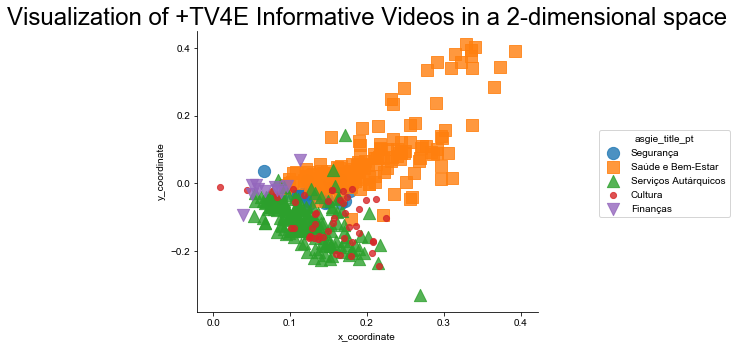

In [20]:
# plot!
import seaborn as sns
import matplotlib.pyplot as plt
sns.lmplot("x_coordinate", "y_coordinate", hue="asgie_title_pt", data=df_videos, fit_reg=False, markers=markers_list, scatter_kws={"s": 150})
# Adjust borders and add title
sns.set(font_scale=2)
plt.title('Visualization of +TV4E Informative Videos in a 2-dimensional space')
plt.subplots_adjust(right=0.80, top=0.90, left=0.12, bottom=0.12)
# Show plot
plt.show()